In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName('Electronics-Sales').getOrCreate()

In [22]:
df = spark.read.option('header', 'true').csv('electronics_sales.csv')

In [4]:
df.show()

+--------------------+----------+----------+-------------------+--------------------+-----------+------+-------------------+------------+
|          event_time|event_type|product_id|        category_id|       category_code|      brand| price|            user_id|user_session|
+--------------------+----------+----------+-------------------+--------------------+-----------+------+-------------------+------------+
|2020-09-24 11:57:...|      view|   1996170|2144415922528452715|electronics.telep...|       null| 31.90|1515915625519388267|  LJuJVLEjPT|
|2020-09-24 11:57:...|      view|    139905|2144415926932472027|computers.compone...|     zalman| 17.16|1515915625519380411|  tdicluNnRY|
|2020-09-24 11:57:...|      view|    215454|2144415927158964449|                null|       null|  9.81|1515915625513238515|  4TMArHtXQy|
|2020-09-24 11:57:...|      view|    635807|2144415923107266682|computers.periphe...|     pantum|113.81|1515915625519014356|  aGFYrNgC08|
|2020-09-24 11:57:...|      view| 

In [5]:
df.describe().show()

+-------+--------------------+----------+------------------+--------------------+------------------+--------+------------------+--------------------+------------+
|summary|          event_time|event_type|        product_id|         category_id|     category_code|   brand|             price|             user_id|user_session|
+-------+--------------------+----------+------------------+--------------------+------------------+--------+------------------+--------------------+------------+
|  count|              885129|    885129|            885129|              885129|            648910|  672765|            885129|              885129|      884964|
|   mean|                null|      null|1906620.5358925082|2.144422967987611...|              null|Infinity|146.32871349826158|1.515915625558836...|        null|
| stddev|                null|      null|1458708.0993291892|6.165105160822446E14|              null|     NaN|296.80768261400095| 3.608468484619973E7|        null|
|    min|2020-09-24 11

In [23]:
df = df.withColumn("date", split(df["event_time"], " ")[0])
df = df.withColumn("hour", split(df["event_time"], " ")[1])
df = df.drop('event_time')
df.show()

+----------+----------+-------------------+--------------------+-----------+------+-------------------+------------+----------+--------+
|event_type|product_id|        category_id|       category_code|      brand| price|            user_id|user_session|      date|    hour|
+----------+----------+-------------------+--------------------+-----------+------+-------------------+------------+----------+--------+
|      view|   1996170|2144415922528452715|electronics.telep...|       null| 31.90|1515915625519388267|  LJuJVLEjPT|2020-09-24|11:57:06|
|      view|    139905|2144415926932472027|computers.compone...|     zalman| 17.16|1515915625519380411|  tdicluNnRY|2020-09-24|11:57:26|
|      view|    215454|2144415927158964449|                null|       null|  9.81|1515915625513238515|  4TMArHtXQy|2020-09-24|11:57:27|
|      view|    635807|2144415923107266682|computers.periphe...|     pantum|113.81|1515915625519014356|  aGFYrNgC08|2020-09-24|11:57:33|
|      view|   3658723|214441592116949818

In [7]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+-----------+-------------+------+-----+-------+------------+----+----+
|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|date|hour|
+----------+----------+-----------+-------------+------+-----+-------+------------+----+----+
|         0|         0|          0|       236219|212364|    0|      0|         165|   0|   0|
+----------+----------+-----------+-------------+------+-----+-------+------------+----+----+



In [8]:
df.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)
 |-- date: string (nullable = true)
 |-- hour: string (nullable = true)



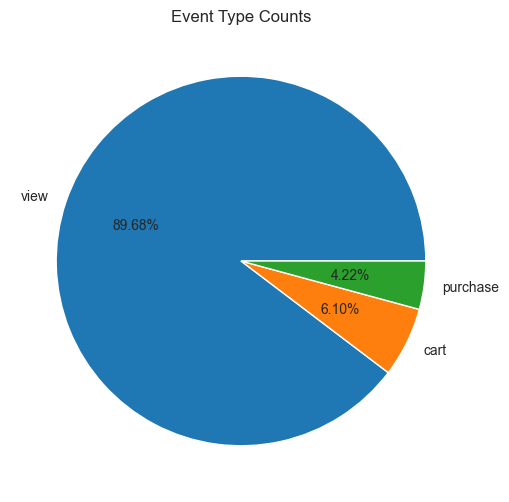

In [37]:
event_type_counts = df.groupBy('event_type').count().orderBy('count', ascending=False).toPandas()
plt.figure(figsize=(10, 6))
plt.pie(event_type_counts['count'], labels=event_type_counts['event_type'], autopct='%1.2f%%')
plt.title('Event Type Counts')
plt.show()

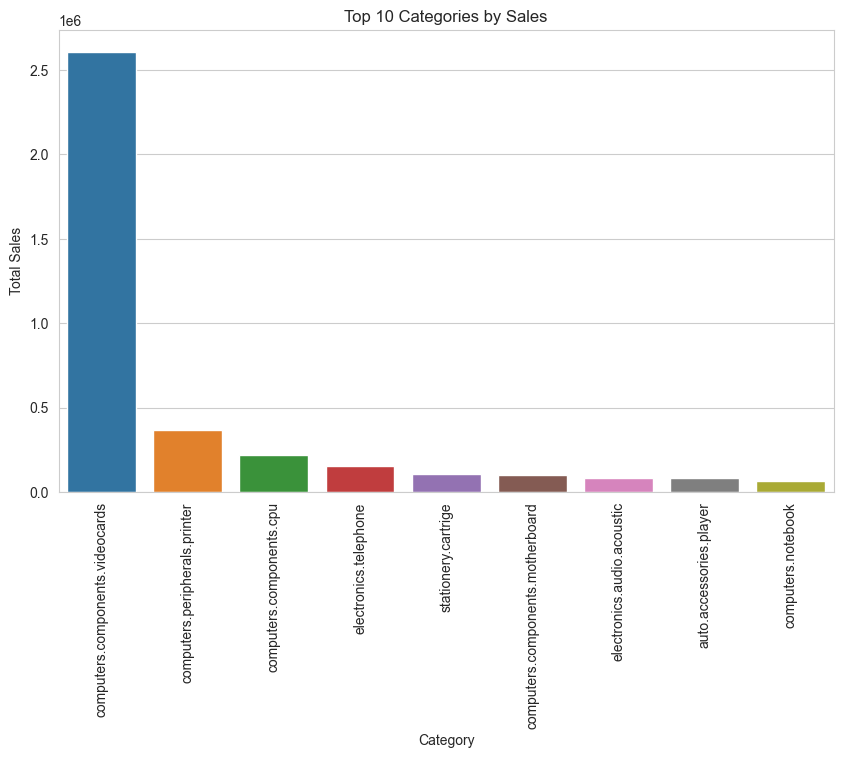

In [29]:
N = 10
sales = (df.filter(df['event_type'] == 'purchase').
         groupBy('category_code').agg(sum('price').alias('total_sales'))
         .orderBy('total_sales', ascending=False).limit(N).toPandas())
plt.figure(figsize=(10, 6))
sns.barplot(x='category_code', y='total_sales', data=sales)
plt.title(f'Top {N} Categories by Sales')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

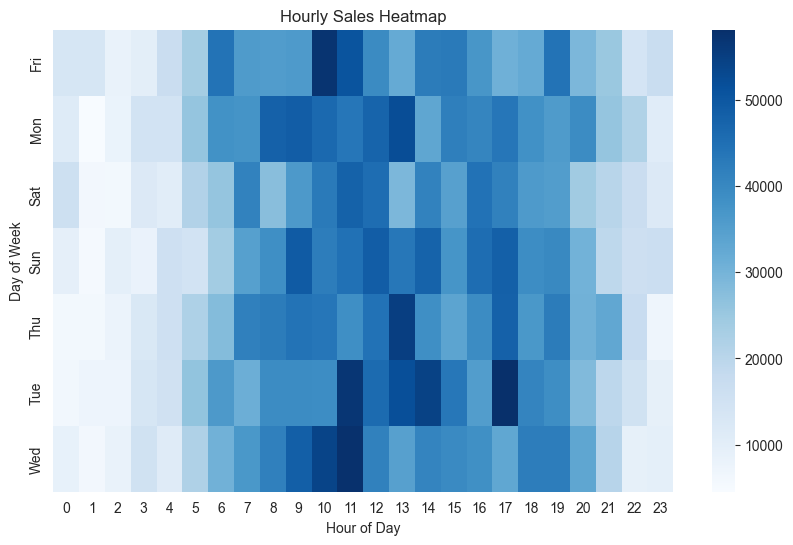

In [32]:
sales = (df.filter(df['event_type'] == 'purchase')
         .withColumn('day_of_week', date_format(df['date'], 'E'))
         .withColumn('hour', hour(df['hour']))
         .groupBy('day_of_week', 'hour')
         .agg(sum('price').alias('total_sales')).toPandas())

sales_pivot = sales.pivot(index='day_of_week', columns='hour', values='total_sales')

plt.figure(figsize=(10, 6))
sns.heatmap(sales_pivot, cmap='Blues')
plt.title('Hourly Sales Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


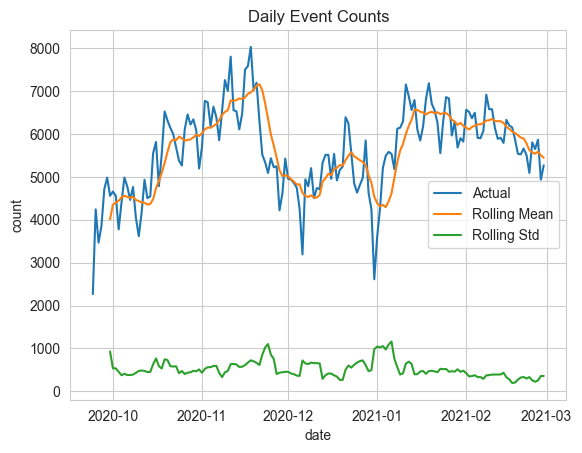

In [11]:
df_date = df.filter(col('date') != '')
df_date = df_date.withColumn('date', to_date(col('date'), 'yyyy-MM-dd'))
df_date = df_date.groupBy('date').count().orderBy('date')
df_date = df_date.selectExpr('date', 'count as count')

pandas_df = df_date.toPandas()
pandas_df.set_index('date', inplace=True)

rolling_mean = pandas_df.rolling(window=7).mean()
rolling_std = pandas_df.rolling(window=7).std()

sns.set_style("whitegrid")
sns.lineplot(data=pandas_df, x=pandas_df.index, y='count', label='Actual')
sns.lineplot(data=rolling_mean, x=rolling_mean.index, y='count', label='Rolling Mean')
sns.lineplot(data=rolling_std, x=rolling_std.index, y='count', label='Rolling Std')
plt.legend(loc='best')
plt.title('Daily Event Counts')
plt.show()


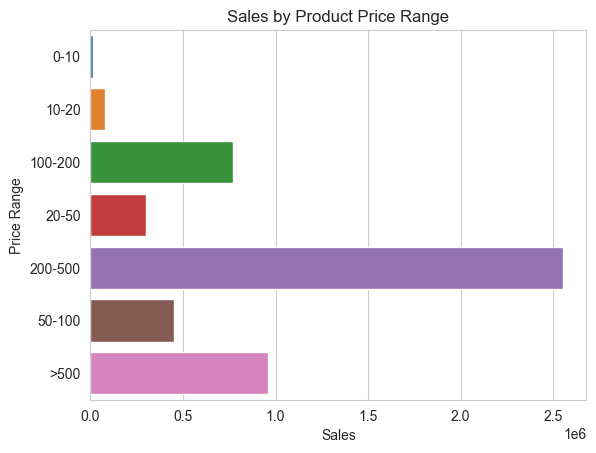

In [47]:
purchase_df = df.filter(df['event_type'] == 'purchase')
purchase_df = purchase_df.withColumn(
    'price_range',
    when(col('price') <= 10, '0-10') \
    .when((col('price') > 10) & (col('price') <= 20), '10-20') \
    .when((col('price') > 20) & (col('price') <= 50), '20-50') \
    .when((col('price') > 50) & (col('price') <= 100), '50-100') \
    .when((col('price') > 100) & (col('price') <= 200), '100-200') \
    .when((col('price') > 200) & (col('price') <= 500), '200-500') \
    .otherwise('>500')
)

sales_df = (purchase_df.groupBy('price_range')
            .agg(sum('price').alias('sales'))
            .orderBy('price_range').toPandas())

sns.barplot(x='sales', y='price_range', data=sales_df)
plt.title('Sales by Product Price Range')
plt.xlabel('Sales')
plt.ylabel('Price Range')
plt.show()